### In this nb we will seek to make the analysis in Exploratory2 more robust by doing a more thorough cleaning of the time series data to remove influence of seasonality and changing variance. We will also compare our distributed lag model with the impulse response from a VAR model and an ARDL model.

In [1]:
from utils import *

<AxesSubplot:xlabel='date'>

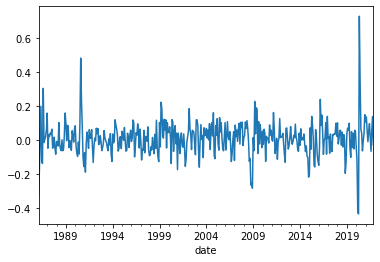

In [2]:
wti = pd.read_csv('data/WTI.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()['spot'].pct_change().dropna()
wti.plot()

In [3]:
av = wti.groupby(wti.index.year).std()
print(len(av))

36


In [4]:
wti_av = wti.index.map(lambda x: av.loc[x.year])
print(len(wti_av) == len(wti))

True


In [5]:
wti = wti/wti_av

<AxesSubplot:xlabel='date'>

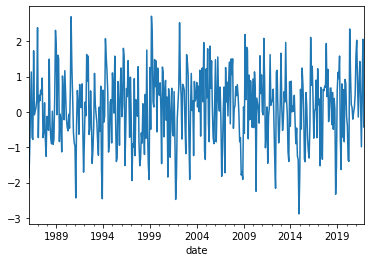

In [6]:
wti.plot()

<AxesSubplot:xlabel='date'>

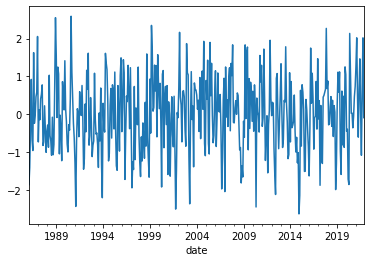

In [7]:
ma = wti.groupby(wti.index.month).mean()
wti_ma = wti.index.map(lambda x: ma.loc[x.month])
wti = wti - wti_ma
wti.plot()

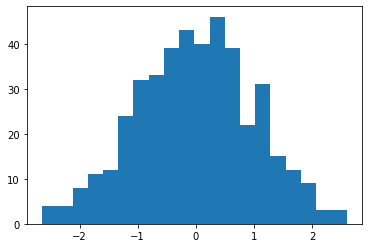

In [8]:
plt.hist(wti, bins=20)
plt.show()

<AxesSubplot:xlabel='date'>

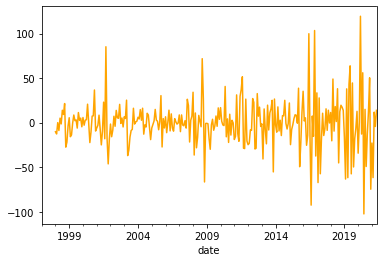

In [9]:
epu = pd.read_csv('data/EPUGlobal.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
epu['MA2'] = epu.GEPU_current.rolling(12).mean()
epu_shock = (epu.GEPU_current - epu.MA2).diff()
epu_shock.plot(color='orange')

<AxesSubplot:xlabel='date'>

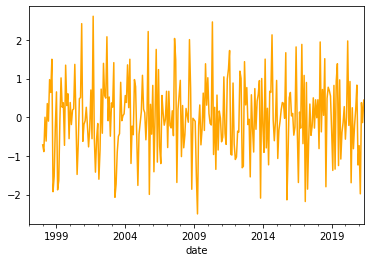

In [10]:
av1 = epu_shock.groupby(epu_shock.index.year).std()
epu_av = epu_shock.index.map(lambda x: av1.loc[x.year])
epu_shock = epu_shock/epu_av
epu_shock.plot(color='orange')

<AxesSubplot:xlabel='date'>

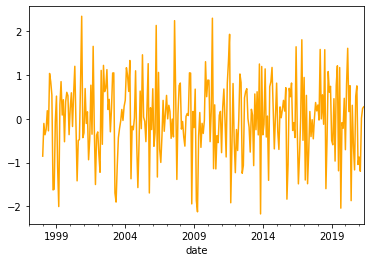

In [11]:
ma1 = epu_shock.groupby(epu_shock.index.month).mean()
epu_ma = epu_shock.index.map(lambda x: ma1.loc[x.month])
epu_shock = epu_shock - epu_ma
epu_shock.plot(color='orange')

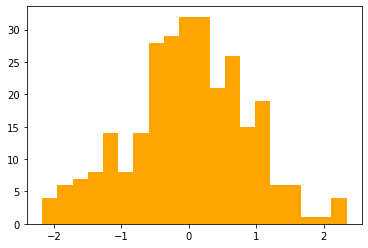

In [12]:
plt.hist(epu_shock, bins=20, color='orange')
plt.show()

In [13]:
df = pd.DataFrame(wti.rename('wti')).join(epu_shock.rename('epu_shock')).dropna()
df.head()

,wti,epu_shock
date,,
1998-01-01,-1.653551,-0.854459
1998-02-01,-0.602923,-0.107426
1998-03-01,-1.241328,-0.365592
1998-04-01,-0.233244,-0.241269
1998-05-01,-0.642636,0.183918


In [14]:
model1 = dl('wti', 'epu_shock', df)
model1.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wti   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.838
Date:                Thu, 30 Dec 2021   Prob (F-statistic):             0.0379
Time:                        23:42:28   Log-Likelihood:                -369.47
No. Observations:                 269   AIC:                             766.9
Df Residuals:                     255   BIC:                             817.3
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0713      0.059      1.209      0.228      -0.045       0.187
epu_shock-lag0     -0.1789      0.078     -2.304      0.022      -0.332      -0.026
epu_shock-lag1     -0.1934      0.078     -2.493      0.013      -0.346      -0.041
epu_shock-lag2     -0.1638      0.071     -2.318      0.021      -0.303      -0.025
epu_shock-lag3      0.0071      0.071      0.101      0.920      -0.132       0.146
epu_shock-lag4     -0.1008      0.073     -1.372      0.171      -0.245       0.044
epu_shock-lag5     -0.1130      0.070     -1.608      0.109      -0.251       0.025
epu_shock-lag6     -0.0833      0.067     -1.245      0.214      -0.215       0.048
epu_shock-lag7     -0.1328      0.067     -1.967      0.050      -0.266       0.000
epu_shock-lag8     -0.0029      0.075     -0.039      0.969      -0.150       0.144
epu_shock-lag9     -0.1141      0.074     -1.544      0.124      -0.260       0.031
epu_shock-lag10    -0.1073      0.070     -1.530      0.127      -0.245       0.031
epu_shock-lag11    -0.0835      0.072     -1.163      0.246      -0.225       0.058
epu_shock-lag12    -0.1317      0.075     -1.747      0.082      -0.280       0.017
==============================================================================
Omnibus:                        1.864   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.394   Jarque-Bera (JB):                1.723
Skew:                          -0.099   Prob(JB):                        0.423
Kurtosis:                       2.662   Cond. No.                         1.85
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

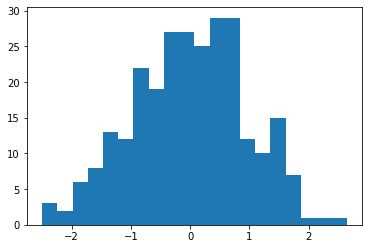

In [15]:
plt.hist(model1.resid, bins=20)
plt.show()

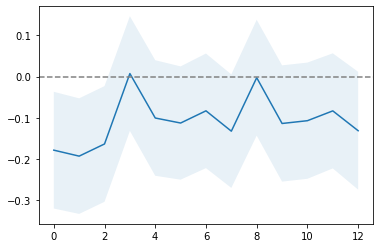

In [16]:
plt.plot(model1.params[1:].reset_index(drop=True))
plt.fill_between([*range(13)], model1.conf_int()[0][1:], model1.conf_int()[1][1:], alpha=.1)
plt.axhline(y=0, color='grey', linestyle='--')

### VAR

In [17]:
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

In [18]:
for l in range(1, 15):
    res = pearsonr(df['wti'].iloc[l:], df['epu_shock'].iloc[:-l])
    print(f'Lag {l}: {res}')

Lag 1: (-0.0968857383986606, 0.10571345703221267)
Lag 2: (-0.0676261982369902, 0.2602509627607838)
Lag 3: (0.06668374116524299, 0.26783405473379157)
Lag 4: (-0.020748439445685038, 0.7309979724429363)
Lag 5: (-0.079050409983494, 0.19040780083845524)
Lag 6: (-0.042496935844984124, 0.48277954469242346)
Lag 7: (-0.07680911979387336, 0.20498446032167122)
Lag 8: (0.0798042320840221, 0.18863436393801628)
Lag 9: (-0.028852478434469912, 0.6356750009276009)
Lag 10: (-0.02319956478891418, 0.7037977945186871)
Lag 11: (-0.03846010153192497, 0.5291757032231912)
Lag 12: (-0.0517366765300583, 0.3980219312073196)
Lag 13: (0.027669511099633108, 0.6520338787546349)
Lag 14: (0.02900293163096788, 0.6370784084063399)


In [19]:
model2 = VAR(df.dropna()).fit(maxlags=5)
model2.summary()

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Dec, 2021
Time:                     23:42:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0592803
Nobs:                     276.000    HQIC:                 -0.113499
Log likelihood:          -729.610    FPE:                   0.795155
AIC:                    -0.229302    Det(Omega_mle):        0.735371
--------------------------------------------------------------------
Results for equation wti
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.039979         0.060175            0.664           0.506
L1.wti               0.153913         0.061422            2.506           0.012
L1.epu_shock        -0.095867         0.070660           -1.357   

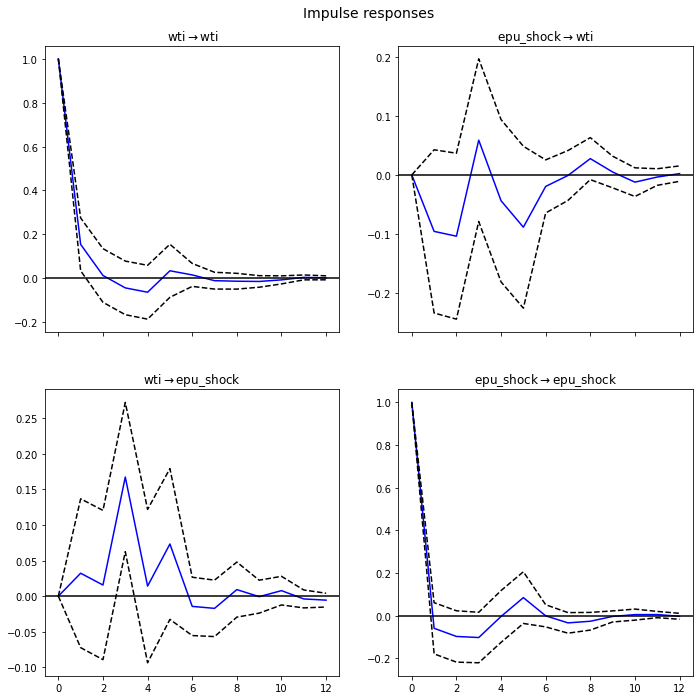

In [20]:
s = model2.irf(12).plot()

### ARDL

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests

In [22]:
gct = grangercausalitytests(pd.DataFrame(epu_shock.rename('epu_shock')).join(wti.rename('wti')).dropna(), 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8890  , p=0.3466  , df_denom=277, df_num=1
ssr based chi2 test:   chi2=0.8986  , p=0.3432  , df=1
likelihood ratio test: chi2=0.8972  , p=0.3435  , df=1
parameter F test:         F=0.8890  , p=0.3466  , df_denom=277, df_num=1


In [23]:
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


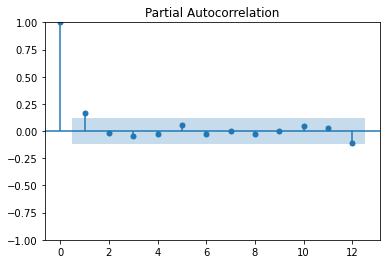

In [24]:
s = plot_pacf(df['wti'], lags=12, alpha=.05)

In [25]:
model3 = ardl('wti', 'epu_shock', df, lags=[1,12])

In [26]:
model3.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wti   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     1.910
Date:                Thu, 30 Dec 2021   Prob (F-statistic):             0.0258
Time:                        23:42:29   Log-Likelihood:                -366.65
No. Observations:                 269   AIC:                             763.3
Df Residuals:                     254   BIC:                             817.2
Df Model:                          14                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0632      0.059      1.063      0.289      -0.054       0.180
wti-lag1            0.1418      0.063      2.251      0.025       0.018       0.266
epu_shock-lag0     -0.1802      0.078     -2.314      0.021      -0.334      -0.027
epu_shock-lag1     -0.1717      0.078     -2.210      0.028      -0.325      -0.019
epu_shock-lag2     -0.1401      0.069     -2.035      0.043      -0.276      -0.005
epu_shock-lag3      0.0248      0.070      0.354      0.723      -0.113       0.163
epu_shock-lag4     -0.1032      0.073     -1.406      0.161      -0.248       0.041
epu_shock-lag5     -0.1020      0.070     -1.467      0.144      -0.239       0.035
epu_shock-lag6     -0.0680      0.067     -1.012      0.312      -0.200       0.064
epu_shock-lag7     -0.1238      0.067     -1.851      0.065      -0.256       0.008
epu_shock-lag8      0.0163      0.076      0.214      0.831      -0.133       0.166
epu_shock-lag9     -0.1167      0.074     -1.584      0.114      -0.262       0.028
epu_shock-lag10    -0.0959      0.070     -1.377      0.170      -0.233       0.041
epu_shock-lag11    -0.0716      0.071     -1.011      0.313      -0.211       0.068
epu_shock-lag12    -0.1237      0.074     -1.671      0.096      -0.269       0.022
==============================================================================
Omnibus:                        1.651   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.438   Jarque-Bera (JB):                1.440
Skew:                           0.008   Prob(JB):                        0.487
Kurtosis:                       2.642   Cond. No.                         2.01
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

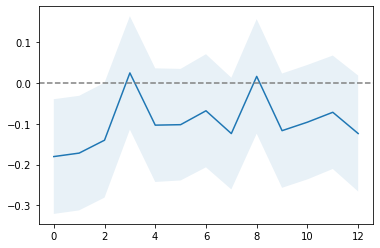

In [27]:
plt.plot(model3.params[2:].reset_index(drop=True))
plt.fill_between([*range(13)], model3.conf_int()[0][2:], model3.conf_int()[1][2:], alpha=.1)
plt.axhline(y=0, color='grey', linestyle='--')

Given that VAR model is dependent on construction, it may be better to use the single equation models. ARDL has a higher adjusted R^2 than DL, which implies it is better at explaining variations in the data.